导入所需库

In [1]:
import pandas as pd
import numpy as np
import torch
import lightning.pytorch as pl

from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import QuantileLoss
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.callbacks import LearningRateMonitor
from torch.utils.data import DataLoader

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
import pickle
import os

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import platform
from datetime import datetime

In [2]:
def get_system_font():
    if platform.system() == 'Darwin':  # macOS
        # macOS 常见中文字体路径
        font_paths = [
            '/System/Library/Fonts/PingFang.ttc',
            '/System/Library/Fonts/STHeiti Light.ttc',
            '/System/Library/Fonts/STHeiti Medium.ttc',
            '/Library/Fonts/Microsoft/SimHei.ttf'
        ]
    else:  # Linux/Windows
        font_paths = [
            '/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc',
            '/usr/share/fonts/truetype/droid/DroidSansFallbackFull.ttf'
        ]
    
    # 尝试找到可用的中文字体
    for path in font_paths:
        if os.path.exists(path):
            return path
            
    # 如果找不到预定义的字体，使用系统默认中文字体
    chinese_fonts = [f for f in fm.findSystemFonts() if 'noto' in f.lower() or 'ping' in f.lower() or 'heiti' in f.lower()]
    return chinese_fonts[0] if chinese_fonts else None

# 设置中文字体
try:
    font_path = get_system_font()
    if font_path:
        plt.rcParams['font.family'] = ['sans-serif']
        font_prop = fm.FontProperties(fname=font_path)
        plt.rcParams['font.sans-serif'] = [font_prop.get_name()]
    else:
        # 使用内置的中文字体
        plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
    plt.rcParams['axes.unicode_minus'] = False  # 正确显示负号
except Exception as e:
    print(f"设置中文字体时出错: {str(e)}")
    # 使用备选方案
    plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']

print(font_prop)

sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:file=/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc:size=10.0


读取数据及数据预处理

In [3]:
# read data
data_path = '../data/'
weather_data = pd.read_csv(data_path + 'neimeng_weather.csv', sep=',')
solar_data = pd.read_csv(data_path + 'neimeng_solar_output.csv', sep=',')
wind_data = pd.read_csv(data_path + 'neimeng_wind_output.csv', sep=',')

weather_data.drop(columns=['id', 'lng', 'lat', 'region_name'], inplace=True)
solar_data.drop(columns=['type'], inplace=True)
wind_data.drop(columns=['type'], inplace=True)

city_code_map = {
    '乌兰察布':	1509,
    '锡林郭勒':	1525,
    '包头':	1502,
    '巴彦淖尔':	1508,
    '阿拉善盟':	1529,
    '呼和浩特':	1501,
    '鄂尔多斯':	1506,
    '乌海':	1503,
    '鄂尔多斯+薛家湾': 1506
}

solar_data['city_name'] = solar_data['city_name'].map(city_code_map)
wind_data['city_name'] = wind_data['city_name'].map(city_code_map)
weather_data.rename(columns={'region_code': 'city_code', 'ts': 'datetime'}, inplace=True)
solar_data.rename(columns={'city_name': 'city_code', 'date_time': 'datetime', 'value': 'solar_output'}, inplace=True)
wind_data.rename(columns={'city_name': 'city_code', 'date_time': 'datetime', 'value': 'wind_output'}, inplace=True)

weather_data['datetime'] = pd.to_datetime(weather_data['datetime'], dayfirst=True)
weather_data.set_index(weather_data['datetime'], inplace=True)
weather_data.drop(columns=['datetime'], inplace=True)

solar_data['datetime'] = pd.to_datetime(solar_data['datetime'], dayfirst=True)
solar_data.set_index(solar_data['datetime'], inplace=True)
solar_data.drop(columns=['datetime'], inplace=True)

wind_data['datetime'] = pd.to_datetime(wind_data['datetime'], dayfirst=True)
wind_data.set_index(wind_data['datetime'], inplace=True)
wind_data.drop(columns=['datetime'], inplace=True)

target_city_code = 1508
mask = weather_data['city_code'] == target_city_code
weather_data = weather_data[mask]
mask = solar_data['city_code'] == target_city_code
solar_data = solar_data[mask]
mask = wind_data['city_code'] == target_city_code
wind_data = wind_data[mask]

solar_data = solar_data.resample('h', closed='right', label='right').mean()
wind_data = wind_data.resample('h', closed='right', label='right').mean()

merged_df = pd.concat([weather_data, solar_data, wind_data], axis=1)
merged_df.dropna(inplace=True)
merged_df.drop(columns=['city_code'], inplace=True)

def deal_missing_data(df_data):
    complete_time_range = pd.date_range(
        start=df_data.index.min(),
        end=df_data.index.max(),
        freq='h'
    )
    initial_missing = complete_time_range.difference(df_data.index)
    print(f"Initial missing timestamps: {len(initial_missing)}")
    if len(initial_missing) == 0:
        print("No need to deal missing data.")
        return df_data

    print("Dealing with missing data.")
    print("Initial missing dates:", pd.Series(initial_missing.date).value_counts())

    df_reindexed = df_data.reindex(complete_time_range)
    df_reindexed['date'] = df_reindexed.index.date
    missing_flag = df_reindexed.drop(columns='date').isna().any(axis=1)
    missing_count_per_day = missing_flag.groupby(df_reindexed['date']).sum()
    print("Missing timestamps per day:")
    print(missing_count_per_day)

    threshold = 8
    days_to_drop = missing_count_per_day[missing_count_per_day > threshold].index
    print(f"\nDays to drop: {len(days_to_drop)}")

    df_cleaned = df_reindexed[~df_reindexed['date'].isin(days_to_drop)].copy()
    df_cleaned.drop(columns='date', inplace=True)
    
    df_filled = df_cleaned.interpolate(method='time')

    expected_range = pd.date_range(
        start=df_filled.index.min(),
        end=df_filled.index.max(),
        freq='h'
    )
    missing_timestamps = expected_range.difference(df_filled.index)
    print(f"Total missing timestamps: {len(missing_timestamps)}")
    print("\nMissing timestamps by date:")
    missing_dates = pd.Series(missing_timestamps.date).value_counts().sort_index()
    print(missing_dates)
    
    return df_filled

df_cleaned = deal_missing_data(merged_df)

df_cleaned.to_csv("../data/one_city_data.csv")

Initial missing timestamps: 48
Dealing with missing data.
Initial missing dates: 2025-02-13    24
2025-02-12    23
2025-02-14     1
Name: count, dtype: int64
Missing timestamps per day:
date
2024-01-01     0
2024-01-02     0
2024-01-03     0
2024-01-04     0
2024-01-05     0
              ..
2025-02-11     0
2025-02-12    23
2025-02-13    24
2025-02-14     1
2025-02-15     0
Length: 412, dtype: int64

Days to drop: 2
Total missing timestamps: 48

Missing timestamps by date:
2025-02-12    24
2025-02-13    24
Name: count, dtype: int64


In [4]:
print("Before normalized:")
print(df_cleaned.iloc[10:15])

scalers = {}

columns_to_scale = [col for col in df_cleaned.columns]
normalized_df = df_cleaned.copy()

for col in columns_to_scale:
    if 'output' in col:
        scaler = MinMaxScaler()
    else:
        scaler = StandardScaler()

    normalized_df[col] = scaler.fit_transform(normalized_df[[col]])
    scalers[col] = scaler

if not os.path.exists('../model'):
    os.mkdir('../model')

with open('../model/scalers.pkl', 'wb') as f:
    pickle.dump(scalers, f)

normalized_df['datetime'] = normalized_df.index

print("\nAfter normalized:")
print(normalized_df.iloc[10:15])

normalized_df.to_csv("../output/normalized_df.csv", index=True, encoding="utf-8-sig")

Before normalized:
                        t2m   ws10m  ws100m      ssrd   tp      rh  \
2024-01-01 11:00:00 -5.3400  5.4026  7.4081  286.9511  0.0  0.5627   
2024-01-01 12:00:00 -4.8384  5.8687  7.7351  388.4978  0.0  0.5411   
2024-01-01 13:00:00 -0.0111  6.0763  7.9036  439.6089  0.0  0.4029   
2024-01-01 14:00:00  0.2727  6.1327  7.9847  432.9600  0.0  0.3896   
2024-01-01 15:00:00  0.5780  5.9767  7.8884  367.9467  0.0  0.3798   

                     solar_output  wind_output  
2024-01-01 11:00:00       946.277     2549.727  
2024-01-01 12:00:00      1294.318     2402.862  
2024-01-01 13:00:00      1230.975     2602.524  
2024-01-01 14:00:00      1227.397     2706.338  
2024-01-01 15:00:00      1165.689     2813.120  

After normalized:
                          t2m     ws10m    ws100m      ssrd        tp  \
2024-01-01 11:00:00 -0.953372  1.382216  0.904447  0.385923 -0.106259   
2024-01-01 12:00:00 -0.917707  1.656826  1.023772  0.775450 -0.106259   
2024-01-01 13:00:00 -0.57447

In [5]:
normalized_df.columns

# 数据验证函数
def validate_dataset(df, name="数据集"):
    """验证数据集的完整性"""
    print(f"\n{name}验证:")
    print(f"总行数: {len(df)}")
    print(f"缺失值统计:")
    print(df.isnull().sum())
    print(f"\n数值范围:")
    print(df.describe())
    return not df.isnull().any().any()

# 在创建数据集之前进行验证
validate_dataset(normalized_df, "规范化数据")


规范化数据验证:
总行数: 9816
缺失值统计:
t2m             0
ws10m           0
ws100m          0
ssrd            0
tp              0
rh              0
solar_output    0
wind_output     0
datetime        0
dtype: int64

数值范围:
               t2m         ws10m        ws100m          ssrd           tp  \
count  9816.000000  9.816000e+03  9.816000e+03  9.816000e+03  9816.000000   
mean      0.000000 -3.691695e-16 -4.082581e-16  1.737268e-16     0.000000   
min      -2.391871 -1.788015e+00 -1.780387e+00 -7.148030e-01    -0.106259   
25%      -0.901206 -7.064284e-01 -8.008784e-01 -7.148030e-01    -0.106259   
50%       0.056376 -2.293824e-01 -1.159584e-01 -6.960155e-01    -0.106259   
75%       0.868079  5.554870e-01  6.987222e-01  6.488299e-01    -0.106259   
max       2.109066  5.078630e+00  4.381639e+00  3.033913e+00    49.624781   
std       1.000051  1.000051e+00  1.000051e+00  1.000051e+00     1.000051   

                 rh  solar_output  wind_output                       datetime  
count  9.816000e+

True

In [12]:
# 数据预处理验证
if normalized_df.isnull().any().any():
    print("警告：数据中存在缺失值")
    normalized_df = normalized_df.fillna(method='ffill').fillna(method='bfill')

# 创建时间索引
normalized_df['time_idx'] = np.arange(1, len(normalized_df) + 1)
normalized_df['group_id'] = '0'
normalized_df['month'] = normalized_df['datetime'].dt.month.astype(str)

# 数据重构为长格式
df_long = normalized_df.melt(
    id_vars=['datetime', 'time_idx', 't2m', 'ws10m', 'ws100m', 'ssrd', 'tp', 'rh'],
    value_vars=['solar_output', 'wind_output'],
    var_name='output_type',
    value_name='target'
)

# 数据验证函数
def validate_dataset(df, name="数据集"):
    """验证数据集的完整性"""
    print(f"\n{name}验证:")
    print(f"总行数: {len(df)}")
    print(f"缺失值统计:")
    print(df.isnull().sum())
    print(f"\n数值范围:")
    print(df.describe())
    return not df.isnull().any().any()

# 在创建数据集之前进行验证
validate_dataset(normalized_df, "规范化数据")
validate_dataset(df_long, "长格式数据")

# 模型参数设置
max_encoder_length = 24 * 2   # 历史输入长度（以时间步为单位）
max_prediction_length = 24 * 7 

# 为了保证每个时间序列足够长，需要保证：min_encoder_length + min_prediction_length <= 序列总长度
min_encoder_length = max_encoder_length  # 此处固定为 max_encoder_length
min_prediction_length = max_prediction_length

training_cutoff = df_long["time_idx"].max() - max_prediction_length

# 数据集划分
training_data = df_long[df_long["time_idx"] <= training_cutoff].copy()

# 创建训练数据集
training_dataset = TimeSeriesDataSet(
    normalized_df[normalized_df['time_idx'] <= training_cutoff],
    time_idx="time_idx",
    target='wind_output',
    group_ids=["group_id"],
    min_encoder_length=min_encoder_length,
    max_encoder_length=max_encoder_length,
    min_prediction_length=min_prediction_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=["group_id"],
    time_varying_known_categoricals=["month"],
    time_varying_known_reals=["time_idx", "t2m", "ws10m", "ws100m", "ssrd", "tp", "rh"],
    time_varying_unknown_reals=["wind_output"],
    target_normalizer=GroupNormalizer(
        groups=["group_id"],
        transformation="softplus"
    ),
    add_relative_time_idx=True,
    add_encoder_length=True,
    # add_target_scales=True,      # 添加目标尺度信息（用于逆归一化）
    allow_missing_timesteps=True  # 允许缺失时间步
)

# 创建验证数据集
validation_dataset = TimeSeriesDataSet.from_dataset(
    training_dataset, 
    normalized_df, 
    predict=True, 
    stop_randomization=True
)

# 创建数据加载器
batch_size = 64
train_dataloader = training_dataset.to_dataloader(
    train=True, 
    batch_size=batch_size, 
    num_workers=10,
    pin_memory=True,
    persistent_workers=True
)
val_dataloader = validation_dataset.to_dataloader(
    train=False, 
    batch_size=batch_size, 
    num_workers=10,
    pin_memory=True,
    persistent_workers=True
)

# 添加数据验证步骤
print("\n数据集信息:")
print(f"训练集大小: {len(training_dataset)}")
print(f"验证集大小: {len(validation_dataset)}")

# 创建TFT模型
lr = 0.005
hs = 32
ah = 2
do = 0.2
hcs = 16
tft = TemporalFusionTransformer.from_dataset(
    training_dataset,
    learning_rate=lr,          
    hidden_size=hs,              
    attention_head_size=ah,       
    dropout=do,                 
    hidden_continuous_size=hcs,   
    output_size=7,
    loss=QuantileLoss(),
    log_interval=10,
    reduce_on_plateau_patience=4,
)

# 配置训练器
trainer = pl.Trainer(
    max_epochs=50,
    accelerator="gpu" if torch.cuda.is_available() else "cpu",
    devices=1,
    callbacks=[
        EarlyStopping(
            monitor="val_loss",
            min_delta=1e-4,
            patience=10,
            verbose=True,
            mode="min"
        ),
        LearningRateMonitor()
    ],
    logger=True,
    enable_progress_bar=True
)

# 训练模型
try:
    trainer.fit(
        model=tft,
        train_dataloaders=train_dataloader,
        val_dataloaders=val_dataloader
    )
    print("\n模型训练完成")
except Exception as e:
    print(f"训练过程中发生错误:\n{str(e)}")
    print(f"PyTorch Lightning 版本: {pl.__version__}")
    print(f"PyTorch 版本: {torch.__version__}")
    raise


规范化数据验证:
总行数: 9816
缺失值统计:
t2m             0
ws10m           0
ws100m          0
ssrd            0
tp              0
rh              0
solar_output    0
wind_output     0
datetime        0
time_idx        0
group_id        0
month           0
dtype: int64

数值范围:
               t2m         ws10m        ws100m          ssrd           tp  \
count  9816.000000  9.816000e+03  9.816000e+03  9.816000e+03  9816.000000   
mean      0.000000 -3.691695e-16 -4.082581e-16  1.737268e-16     0.000000   
min      -2.391871 -1.788015e+00 -1.780387e+00 -7.148030e-01    -0.106259   
25%      -0.901206 -7.064284e-01 -8.008784e-01 -7.148030e-01    -0.106259   
50%       0.056376 -2.293824e-01 -1.159584e-01 -6.960155e-01    -0.106259   
75%       0.868079  5.554870e-01  6.987222e-01  6.488299e-01    -0.106259   
max       2.109066  5.078630e+00  4.381639e+00  3.033913e+00    49.624781   
std       1.000051  1.000051e+00  1.000051e+00  1.000051e+00     1.000051   

                 rh  solar_output  wind_out

/home/elu/software/anaconda3/envs/TFT/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/home/elu/software/anaconda3/envs/TFT/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss   

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Metric val_loss improved. New best score: 0.113


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.113. Signaling Trainer to stop.



模型训练完成


In [9]:
# 预测
if trainer.is_global_zero:
    try:
        raw_predictions = tft.predict(
            val_dataloader,
            mode="raw",
            return_x=True,
            trainer_kwargs={"accelerator": "gpu" if torch.cuda.is_available() else "cpu"}
        )
        
        # 输出预测结果
        print("\n预测完成")
        print(f"预测结果 shape: {raw_predictions[0]['prediction'].shape}")
        print("预测时间范围:",
              normalized_df[normalized_df['time_idx'] > training_cutoff]['datetime'].min(),
              "至",
              normalized_df[normalized_df['time_idx'] > training_cutoff]['datetime'].max())
    except Exception as e:
        print(f"预测过程中发生错误: {str(e)}")
        raise

Trainer will use only 1 of 3 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=3)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2]



预测完成
预测结果 shape: torch.Size([1, 168, 7])
预测时间范围: 2025-02-06 01:00:00 至 2025-02-15 00:00:00


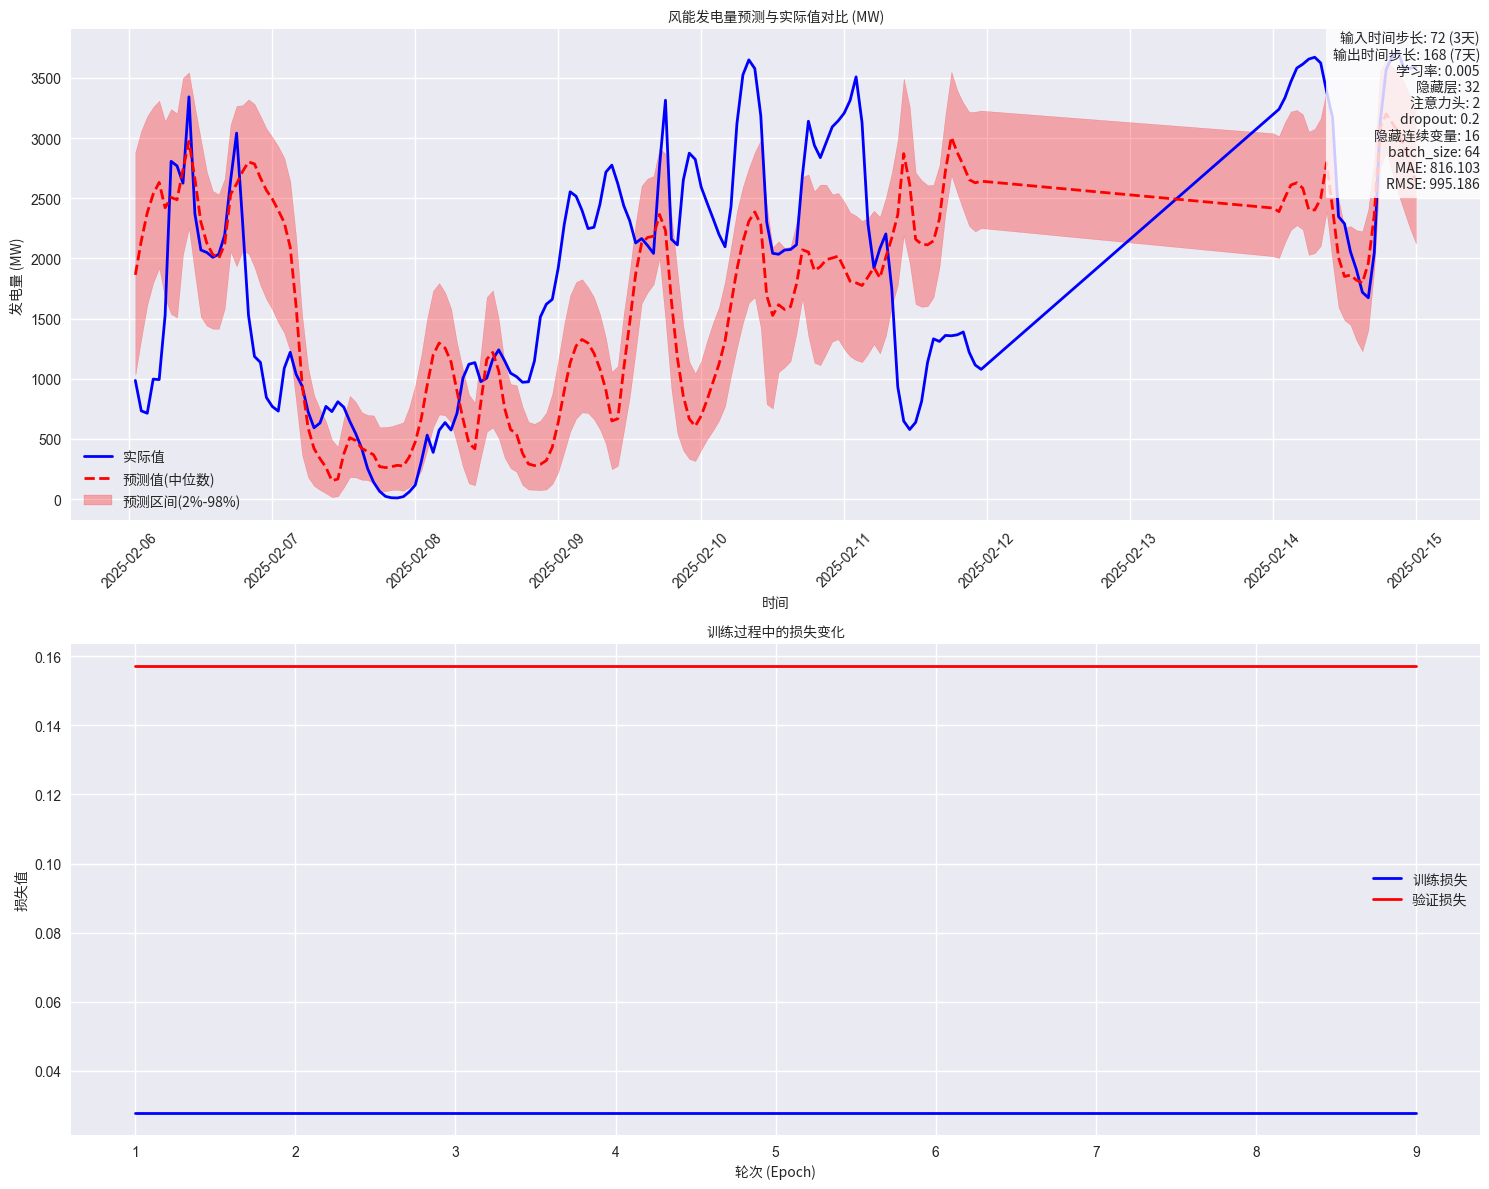


评估指标 (前168个时间步):
平均绝对误差 (MAE): 816.10 MW
均方根误差 (RMSE): 995.19 MW


In [10]:
# 获取验证集的实际值和预测结果
val_data = normalized_df[normalized_df['time_idx'] > training_cutoff]
actual_values = val_data['wind_output'].values

# 处理预测结果
predictions = raw_predictions[0]['prediction'].cpu().numpy()
pred_median = np.median(predictions, axis=2)
pred_low = predictions[:, :, 0] # 2%
pred_high = predictions[:, :, -1] # 98%

# 加载标准化器
with open('../model/scalers.pkl', 'rb') as f:
    scalers = pickle.load(f)

# 获取太阳能发电量的标准化器
solar_scaler = scalers['wind_output']

# 反标准化处理
def inverse_transform_data(normalized_values):
    """
    使用 MinMaxScaler 进行反标准化
    Args:
        normalized_values: 归一化后的值
    Returns:
        反归一化后的值
    """
    # 确保输入是2D数组
    if normalized_values.ndim == 1:
        normalized_values = normalized_values.reshape(-1, 1)
    return solar_scaler.inverse_transform(normalized_values).ravel()

# 对预测值和实际值进行反标准化
actual_values_denorm = inverse_transform_data(actual_values)
pred_median_denorm = inverse_transform_data(pred_median[0])
pred_low_denorm = inverse_transform_data(pred_low[0])
pred_high_denorm = inverse_transform_data(pred_high[0])

# 创建图形
plt.style.use('seaborn-v0_8')
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# 1. 预测结果与真实值对比图
n_steps = max_prediction_length
time_range = val_data['datetime'].values[:n_steps]

# 绘制实际值与预测值
ax1.plot(time_range, actual_values_denorm[:n_steps], 'b-', label='实际值', linewidth=2)
ax1.plot(time_range, pred_median_denorm[:n_steps], 'r--', label='预测值(中位数)', linewidth=2)

# 绘制预测区间
ax1.fill_between(
    time_range,
    pred_low_denorm[:n_steps],
    pred_high_denorm[:n_steps],
    alpha=0.3,
    color='r',
    label='预测区间(2%-98%)'
)

# 计算评估指标
mae = np.mean(np.abs(pred_median_denorm[:n_steps] - actual_values_denorm[:n_steps]))
rmse = np.sqrt(np.mean((pred_median_denorm[:n_steps] - actual_values_denorm[:n_steps])**2))

# 设置第一个子图的属性
ax1.set_title(f'风能发电量预测与实际值对比 (MW)', fontproperties=font_prop)

# 格式化统计指标，保留3位小数
stats_text = (
    f'输入时间步长: {max_encoder_length} ({int(max_encoder_length / 24)}天)\n'
    f'输出时间步长: {max_prediction_length} ({int(max_prediction_length / 24)}天)\n'
    f'学习率: {lr}\n'
    f'隐藏层: {hs}\n'
    f'注意力头: {ah}\n'
    f'dropout: {do}\n'
    f'隐藏连续变量: {hcs}\n'
    f'batch_size: {batch_size}\n'
    f'MAE: {mae:.3f}\n'
    f'RMSE: {rmse:.3f}'
)

# 设置文本位置和格式
ax1.text(
    1,  # 右对齐
    1,  # 顶部对齐
    stats_text,
    transform=ax1.transAxes,  # 使用轴的相对坐标
    horizontalalignment='right',  # 右对齐
    verticalalignment='top',  # 顶部对齐
    bbox=dict(  # 添加文本框
        facecolor='white',
        alpha=0.8,
        edgecolor='none',
        pad=5
    ),
    fontproperties=font_prop if font_prop else None,  # 如果font_prop不可用则使用默认字体
    fontsize=10
)

ax1.set_xlabel('时间', fontproperties=font_prop)
ax1.set_ylabel('发电量 (MW)', fontproperties=font_prop)
ax1.legend(prop=font_prop)
ax1.grid(True)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

# 2. 训练损失曲线
train_losses = []
val_losses = []
for i in range(len(trainer.callback_metrics)):
    metrics = trainer.callback_metrics
    if 'train_loss' in metrics and 'val_loss' in metrics:
        train_losses.append(metrics['train_loss'].cpu().numpy())
        val_losses.append(metrics['val_loss'].cpu().numpy())

epochs = range(1, len(train_losses) + 1)

# 绘制损失曲线
ax2.plot(epochs, train_losses, 'b-', label='训练损失', linewidth=2)
ax2.plot(epochs, val_losses, 'r-', label='验证损失', linewidth=2)

# 设置第二个子图的属性
ax2.set_title('训练过程中的损失变化', fontproperties=font_prop)
ax2.set_xlabel('轮次 (Epoch)', fontproperties=font_prop)
ax2.set_ylabel('损失值', fontproperties=font_prop)
ax2.legend(prop=font_prop)
ax2.grid(True)

# 调整布局
plt.tight_layout()

# 创建保存图片的目录
save_dir = '../figures'
os.makedirs(save_dir, exist_ok=True)

# 保存图片
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

fig.savefig(
    f'{save_dir}/{timestamp}_in{int(max_encoder_length / 24)}d_out{int(max_prediction_length / 24)}d.png',
    dpi=300,  # 设置分辨率
    bbox_inches='tight',  # 自动调整边界
    pad_inches=0.1  # 设置边距
)

plt.show()

print(f"\n评估指标 (前{n_steps}个时间步):")
print(f"平均绝对误差 (MAE): {mae:.2f} MW")
print(f"均方根误差 (RMSE): {rmse:.2f} MW")